# Stitch Images
### Use SWIFT key point to find matches on both images that we can use to stitich images together


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import sys 
import os
import skimage.io

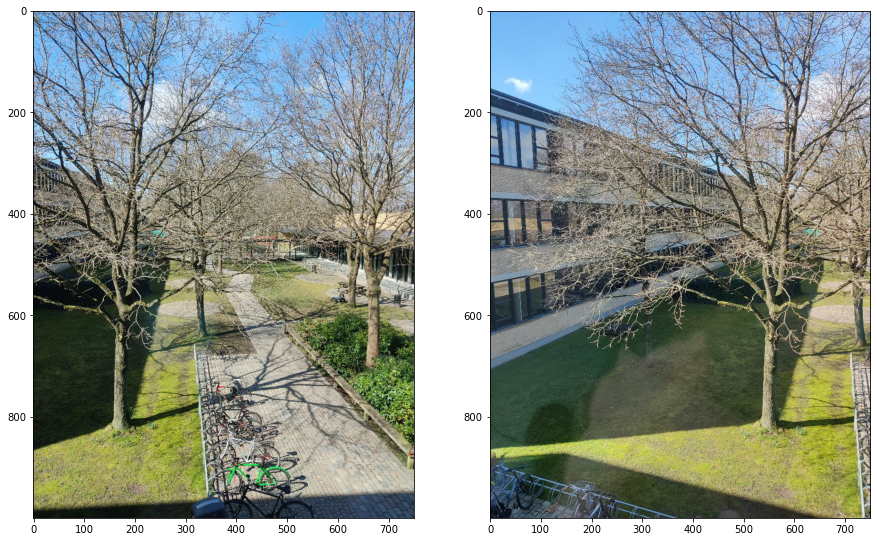

In [2]:
# Read the images 
im1 = skimage.io.imread('im1.jpg')
im2 = skimage.io.imread('im2.jpg')

fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(im1)
ax[1].imshow(im2)

### Use CV2 to detect the matches and descriptors
https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html
https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html

In [3]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)

# BFMatcher with default params, Find the keypoints 
# For each descriptor in the first set, this matcher finds the closest descriptor in
# the second set by trying each one. This descriptor matcher supports masking permissible 
# matches of descriptor sets.
bf = cv2.BFMatcher(crossCheck=True)
matches = bf.match(des1,des2)
     
print('Number of matches:',len(matches))

Number of matches: 2455


#### Visualize the matches in boh images 

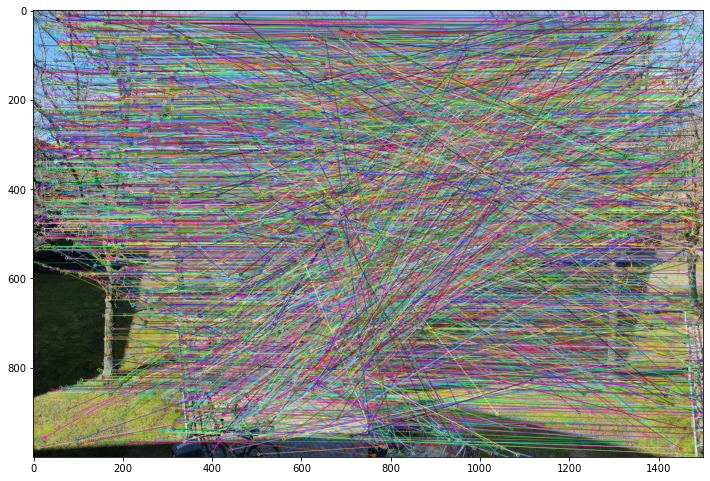

In [4]:
img3 = cv2.drawMatches(im1, kp1, im2, kp2, matches, None, flags=2)
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(img3)

## Use RANSAC algorithm to estimate the Homography matrix:<br>
We have 9 unknowns as the Homography it's 3 by 3. As we can only compute the homography matrix up to a scale Factor, we drop one of unknows. Overall we have 8 constrains. So we'll need 4 pair of points to solve these 8 constrains. <br>
For numerically estability and better accuracy in the estimation we'll always try to use the maximum number of matches.

In [60]:
def hom(Q):
    """
    Function that given a 2d or 3d point or set of points it transforms into homogenous form. 
    
    ARGUMENTS
    ---------
    Q -> np.array where te points have to be in column vectors. (2,n) or (3,n)
    
    RETURNS
    -------
    Q_tmp -> np.array (2+1, n) or (3+1, n)
    """
    n = Q.shape[1]
    Q_tmp = np.vstack([Q, np.ones(n)])
    
    return Q_tmp

In [61]:
def select_points_from_matches(matches, num_pairs:int=None)->list:
    """
    Given the matches from 2 images obtained with cv2.BFMatcher, we select a number of pairs points.
    
    PARAMETERS:
    Matches-> cv2.DMatch objects
    num_pair_points -> number of pair points we want to select on both images
    
    RETURNS:
    list_kp1: 2d array dimensions (3,num_pairs). Colection of points in homogenous form [x, y, 1]^T from the 1st image.
    list_kp2: 2d array dimensions (3,num_pairs). Colection of points in homogenous form [x, y, 1]^T from the 2nd image.
    """
    
    if num_pairs:
        # Select n number of pairs random matches 
        matches_tmp = np.random.choice(matches, num_pairs, replace=False)
        
        # Initialize arrays 
        list_kp1 = np.zeros((3, num_pairs))
        list_kp2 = np.zeros((3, num_pairs))
    else: 
        # If we don't specify the number of points, we simply select all the points
        matches_tmp = matches
        # Initialize arrays 
        list_kp1 = np.zeros((3, len(matches)))
        list_kp2 = np.zeros((3, len(matches)))

    
    # Convert the match DMatch object into points 
    
    # For each match...
    for i, mat in enumerate(matches_tmp):

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx # The index or row of the kp1 interest point matrix that matches
        img2_idx = mat.trainIdx # The index or row of the kp2 interest point matrix that matches

        # x - columns
        # y - rows
        # Get the coordinates
        point_im1 = np.r_[np.array(kp1[img1_idx].pt), 1]
        point_im2 = np.r_[np.array(kp2[img2_idx].pt), 1]

        # Append to each list
        list_kp1[:,i] = point_im1
        list_kp2[:,i] = point_im2
    
    return list_kp1, list_kp2

In [48]:
x1, x2 = select_points_from_matches(matches)
x1.T

array([[  4.7585187 , 219.68722534,   1.        ],
       [  5.28581238, 224.52708435,   1.        ],
       [  6.28771353, 441.19073486,   1.        ],
       ...,
       [746.29309082, 177.06289673,   1.        ],
       [746.57318115, 109.65132141,   1.        ],
       [746.96063232, 821.52154541,   1.        ]])

In [7]:
p1, p2 = select_points_from_matches(matches, 4)
p1.shape, p2.shape

((3, 4), (3, 4))

In [62]:
def crossOp(v):
    """
    v: Vector. The dimensions doesn't matter. Must be a 3d vector
    Cv : It's the cross operation between the vector and itself. It follows the skew-symmetric matrix form 
    """
    # Check the vector has appropiate form, we want a (3,) 
    if v.shape == (3,1):
        v = np.squeeze(v, axis=1)
    elif v.shape == (1,3):
        v = np.squeeze(v, axis=0)
    else:
        pass
            
    Cv = np.matrix(np.array([[0, -v[2], v[1]],[v[2], 0, -v[0]], [-v[1], v[0], 0]]))
    return Cv

In [63]:
def squeezdim(v):
    """
    Function that squeezes a vetor into a the form (n,)
    v: vector of dimension n.     
    """
    try:
        m,n = v.shape
    except ValueError:
        return v
    if m>n: 
        v = np.squeeze(v, axis=1)
    else:
        v = np.squeeze(v, axis=0)
    return v

In [64]:
def matrix_B(q1, q2):
    """
    Creates a B matrix applying Kroneker product. 
        -1st. Corssproduct on vector q in itslef (qxq):  Uses the approach of a skew symetric matrix.
        -2nd. Krokener product: B = Qi⊗[qi]x
        
    We estimate B in order to find the Homography matrix: 
        - Estimate the Homography matrix:
            We want to relate a set of points on 2D with a set of points in 2D. 
            q1 = [x, y]
            q2 = [x, y]

    
    ARGUMENTS 
    q1-> 2d point in Homogenous form. (3,1) -> [x, y, 1]^T
    q2-> 2d point in Homogenous form. (3,1) -> [x, y, 1]^T
    
    RETURNS:
    B -> Matrix created with kroneker product
    """
    
    # Squeez dimesions of q to apply Cross Operation 
    q1 = squeezdim(q1)

    # Create the Skeweness matrix [p1]x
    q1 = crossOp(q1)
    
    # Squeeze vector Q
    q2 = squeezdim(q2)
    
    # Appply Kroneker Product
    for i in range(len(q2)):
        # Check if the first element it's 0 to create matrix
        if not i:
            B = q2[i] * q1
        else:  # If it's not the first element just concatenate the matrices
            B = np.concatenate((B, q2[i]*q1),1)
    return B

In [65]:
def hest(Q1, Q2, norm:bool=False):
    """
    Estimation of the homography matrix. 
    Given a set of points, (min should be 4 points, as the homography has 8 degrees of freedom) calculates the B matrix
    and applies singular value decomposition (SVD) to estimate the homography matrix H.
    
    Following the equation: q1 x H*q2:
        q1: 2D points in inhomogeneous form. [x, y].T 
        q2: 2D points in inhomogeneous form. [x, y].T
        H: Homography matrix (3,3)
    
    ARGUMENTS:
    Q1-> set of 2D points in Homogenous form. (3,n)
    Q2-> set of 2D points in homogenous form. (3,n)
    
    RETURNS
    H-> Estimation of the Homography Matrix (3,3)
    """
    
    # Check the dimensions and if the same poits were given.
    Q1 = np.array(Q1)
    Q2 = np.array(Q2)

    # Check the same number of pooints were given 
    if Q1.shape != Q2.shape:
        print("Different number of points were given, check that Q1 and Q2 have same dimensions")
        return
    n = Q1.shape[1]
    # Calculate B Matrix 
    for i in range(n):
        if not i:
            B = matrix_B(Q1[:,i],Q2[:,i])
        else:
            B = np.concatenate([B, matrix_B(Q1[:,i], Q2[:,i])])
    
    # Estimation of H: SVD
    _, s, eigenvec = np.linalg.svd(B)
    # Find the min Eigenvalue
    idx = np.where(s==min(s))
    # Select the eigenvector correspondent to the eigenvalue
    H = eigenvec[idx]
    # Reshape the array into a matrix form 
    H = H.reshape((3,3), order='F')
    # Scale it 
    if not norm:
        H = H/H[-1,-1]
        return H
    return H

In [41]:
p1_probe = np.array([(746.9606323242188, 821.5215454101562),
  (746.9606323242188, 821.5215454101562),
  (746.9606323242188, 821.5215454101562),
  (746.9606323242188, 821.5215454101562)])
 
p2_probe = np.array([(335.14508056640625, 995.3754272460938),
  (335.14508056640625, 995.3754272460938),
  (335.14508056640625, 995.3754272460938),
  (335.14508056640625, 995.3754272460938)])

p1_probe.shape

(4, 2)

In [66]:
def hest_al(q1, q2):
#     (4,2)
    B = []
    for p, q in zip(q1, q2):
        # To fix dimensions
        q = np.append(q, 1)

        m = np.array([
                        [     0,   -1,  p[1]],
                        [     1,    0, -p[0]],
                        [ -p[1], p[0],     0]
                        ])
        # Kronecker product
        b = np.kron(q[:, None].T, m)
        B.append(b)

    B = np.vstack(np.array(B))
    _, _, vh = np.linalg.svd(B, full_matrices=True, compute_uv=True)
    
    H = vh[-1]
    H = H.reshape((3, 3), order='F')

    return H

In [39]:
H_p_al = hest_al(p1_probe, p2_probe)
H_p_al

array([[-7.68936252e-04,  1.36108183e-03, -7.39892351e-01],
       [-1.36204267e-03,  1.77438689e-04,  6.72707999e-01],
       [ 1.20699082e-05,  7.87189178e-07, -4.35052812e-03]])

In [40]:
p1_probe = hom(p1_probe.T)  # (3, n)
p1_probe.shape

(3, 4)

In [42]:
p1_probe = hom(p1_probe.T)  # (3, n)
p2_probe = hom(p2_probe.T)
H_pp = hest(p1_probe, p2_probe, True)
H_pp

matrix([[-7.68936252e-04,  1.36108183e-03, -7.39892351e-01],
        [-1.36204267e-03,  1.77438689e-04,  6.72707999e-01],
        [ 1.20699082e-05,  7.87189178e-07, -4.35052812e-03]])

In [ ]:
H_est = hest(p1,p2)
H_est

In [67]:
def inhom(Q):
    """
    Returns the Point/s Q in inhomogenous form. 
    Given Q divides by the scale:
        - 2D points:
            [sx, sy, s]/s = [x, y, 1] and we return [x, y]
        - 3D points:
            As the scale is 1 we divide by one and return everything but the last column.
    
    ARGUMENTS
    ---------
    Q -> Point or set of points in the form of column vector. (3, n) or in case of 3d points (4,n)
    
    RETURNS
    -------
    Q_tmp -> Points in inhomogenous form. 2d: (2,n), 3d: ()
    """
    # Get the scale 
    s = Q[-1,:]
    
    # Divide by the scale at select everything but the last row
    Q_tmp = (Q/s)[:-1,:]
    
    return Q_tmp

In [68]:
def dist_point_homography(H,p1,p2):
    """
    Given an Homography matrix and 2 matching points from to different Images, calculates the distance between these
    two points once we have "projected" the points into the second point plane.
    
        d = ||Π(Hp2) − Π(p1)||^2 + ||Π(H−1p1i) − Π(p2i)||^2 
            
            u = ||Π(Hp2) − Π(p1)||^2
            v = ||Π((H^-1)p1) − Π(p2)||^2
                     
        Computing the norm of a vector as default norm 2.
        
    ARGUMENTS
    ---------
    H  -> Homography matrix 
    p1 -> Point 2d in homogenous coordinates (3,n)
    p2 -> Point 2d in homogenous coordinates (3,n)
    
    RETURNS
    -------
    d -> Distance from pq to p2 
    """
    # Calculate the invers og the homogaphy 
    H_inv = np.linalg.inv(H)

    # Compute norm of the vectors separately
    u = np.sqrt(np.sum(np.array(inhom(p1) - inhom(H@p2))**2, axis = 0))
    v = np.sqrt(np.sum(np.array(inhom(p2) - inhom(H_inv@p1))**2, axis=0))
    
    # Compute distance
    d = u + v
    
    return d

In [19]:
v1 = np.array([(746.9606323242188, 821.5215454101562)])
v2 = np.array([(335.14508056640625, 995.3754272460938)])
v1 = hom(v1.T)
v2 = hom(v2.T)
v1

array([[746.96063232],
       [821.52154541],
       [  1.        ]])

In [20]:
dist_point_homography(H_rpe, v1, v2)

array([2.80506586e-12])

In [21]:
d = dist_point_homography(H_est, p1, p2)
d

array([1.09748690e-08, 8.98108429e-08, 1.01520326e-07, 1.39449395e-07])

Now we can run a RANSAC algorithm. Set the threshold to:

$\tau = 3.84*\sigma^2$ <br>
$\tau = 3.84*3^2  = 34.47$

In [73]:
def isinlier(H, p1, p2, sigma:int=3):
    """
    
    Given a set of points1 and a set of points2 
    
        Given a sigma, calculates the tau, minumum distance to consider the point an outlier in the RANSAC algorithm.
    
    ARGUMENTS
    ---------
    H  -> Homography matrix (3,3)
    p1 -> Point 2d in homogenous coordinates (3,n)
    p2 -> Point 2d in homogenous coordinates (3,n)
    
    RETURNS
    -------
    d -> boolean array.

    """
    
    # Caclulate threshold 
    tau = 3.84*sigma**2
    
    # Calculate distance 
    d = dist_point_homography(H, p1, p2)
    
    return d<tau    

In [23]:
inlier = isinlier(H_est, p1, p2)
inlier

array([ True,  True,  True,  True])

As we are using these for points to estimate the homography matrix, the points we are using will normally be inliers

### Check the all the points for innliers and outliers 

In [24]:
points1, points2 = select_points_from_matches(matches)
points1.shape

(3, 2455)

In [25]:
d_t = isinlier(H_est, points1, points2)
points1.shape

(3, 2455)

In [26]:
d_t.shape, sum(d_t)

((2455,), 5)

In [27]:
points1, points2 = select_points_from_matches(matches)
points1.shape

(3, 2455)

In [70]:
def hest_al(q1, q2):
#     (2,n)
    B = []
    for p, q in zip(q1, q2):
        # To fix dimensions
        q = np.append(q, 1)

        m = np.array([
                        [     0,   -1,  p[1]],
                        [     1,    0, -p[0]],
                        [ -p[1], p[0],     0]
                        ])
        # Kronecker product
        b = np.kron(q[:, None].T, m)
        B.append(b)

    B = np.vstack(np.array(B))
    _, _, vh = np.linalg.svd(B, full_matrices=True, compute_uv=True)
    
    H = vh[-1]
    H = H.reshape((3, 3), order='F')

    return H

In [80]:
def RANSAC(matches, n_iterations:int=200):
    
    # Initialize some variables 
    N_opt = 0 
    H_opt = None 
    points1_opt = None 
    points2_opt = None 
    
    # Convert the matches into points
    points1, points2 = select_points_from_matches(matches)
#     points1 = points1[:-1,:]
#     points2 = points2[:-1,:]
    
#     q1 = hom(points1_h)
#     q2 = hom(points2_h)
    # Iterate until we obtain an optimal homography matrix 
    for i in range(n_iterations):
        # Print number of iterations

        # Select 4 pair of points 
        p1, p2 = select_points_from_matches(matches, 4)  # p1 -> (3,4)
        
#         p1 = p1[:,:-1].T
#         p2 = p2.T[:,:-1]
#         print(p1.shape)
#         p1 = np.random.choice(points1[0,:], 4, replace=False)
#         p2 = np.random.choice(points2[0,:], 4, replace=False)
        
        # Estimate the Homography matrix from the 4 pair of points.
        H_tmp = hest(p1, p2)
        
        # Calculate the inliers of all the points 
        inliers_idx = isinlier(H_tmp, points1, points2)
        
        N_tmp = sum(inliers_idx)
        
        if i % 10 == 0:
            print(f'Iteration number: {i}')
            print(N_tmp)
            
        # Check if we have more inliers in this iteration
        if N_tmp>N_opt:
            N_opt = N_tmp
            H_opt = H_tmp
            
            if (H_tmp == H_tmp).all():
                print('Problem')
            points1_opt = points1[:, inliers_idx]
            points2_opt = points2[:, inliers_idx]
       

    return N_opt, H_opt, points1_opt, points2_opt    

In [81]:
N, H, poin1, poin2 = RANSAC(matches)

Iteration number: 0
4
Problem
Problem
Problem
Iteration number: 10
4
Problem
Iteration number: 20
5
Iteration number: 30
5
Iteration number: 40
8
Iteration number: 50
13
Problem
Iteration number: 60
9
Iteration number: 70
13
Iteration number: 80
6
Iteration number: 90
7
Iteration number: 100
4
Iteration number: 110
4
Iteration number: 120
6
Iteration number: 130
13
Iteration number: 140
10
Iteration number: 150
7
Iteration number: 160
11
Iteration number: 170
4
Problem
Iteration number: 180
4
Iteration number: 190
5


In [82]:
N

970

In [129]:
H_est

matrix([[-1.48541084e+00, -2.18190787e+00,  5.15746144e+02],
        [-2.28139040e+00, -2.03792287e+00,  6.08514499e+02],
        [-3.23953547e-03, -3.66380924e-03,  1.00000000e+00]])

In [133]:
(H == H_est).any()

True

In [110]:
H_al = np.array([[ 2.29309422e-03,  3.96717023e-05, -9.32605404e-01],
        [ 6.36177717e-04,  2.08121568e-03, -3.60881446e-01],
        [ 1.32103988e-06,  2.09973221e-08,  1.32113793e-03]])

In [111]:
H_al

array([[ 2.29309422e-03,  3.96717023e-05, -9.32605404e-01],
       [ 6.36177717e-04,  2.08121568e-03, -3.60881446e-01],
       [ 1.32103988e-06,  2.09973221e-08,  1.32113793e-03]])

In [125]:
with open('p1.npy', 'rb') as f:
    a = np.load(f)
    
with open('p2.npy', 'rb') as f:
    b = np.load(f)

In [132]:
a.shape

(2411, 2)

In [126]:
def distance_approx(H, q1, q2, p1, p2):
    """
    q1: inhom (2,1) Image 1
    q2: inhom (2,1) Image 2
    
    p1: hom (3,1) Image 1
    p2: hom (3,1) Image 2
    
    """
    
    p2_map = H @ p2
    p2_map = p2_map[:-1] / p2_map[-1]
    term1 = np.linalg.norm((q1 - p2_map))
    
    p1_map = np.linalg.inv(H) @ p1
    p1_map = p1_map[:-1] / p1_map[-1]
    term2 = np.linalg.norm((q2 - p1_map))
    return term1 + term2

In [ ]:
a_hom = hom(a.T).T
b_hom = hom(b.T).T

In [148]:
a_hom.shape

(2411, 3)

In [144]:
a_hom[0], b_hom[0], a[0], b

(array([  2.47776365, 307.1368103 ,   1.        ]),
 array([388.31799316,  59.28636932,   1.        ]),
 array([  2.47776365, 307.1368103 ]),
 (2,))

In [145]:
distance_approx(H_al, a[0], b[0], a_hom[0], b_hom[0])

568.7677378932877

In [138]:
for i in range(a.T.shape[1]):
    print(distance_approx(H_al, a[i], b[i], a_hom[i], b_hom[i]))

568.7677378932877
1208.0130961999535
9.60609506076307
5.439348842426918
453.11821196219296
1301.7595398309668
185.59691627946057
2.673370628319123
4.01528445467033
3.5142616792266397
953.0627850826648
590.263989269858
4.997886009006714
628.6655451299953
1175.6107404132772
3.6959254987824535
2.999429718209054
2.999429718209054
14.505570560272204
8.980744732305432
161.84734090028948
4.411551331934128
772.802885303548
515.5686824725057
7.358378848477411
6.226225469738514
6.226225469738514
160.30522458835293
4.308167717732648
690.9750278953268
4.756406848492699
880.2069879827199
50.32121249269983
263.0253592653646
818.851883051035
189.8034763012924
437.43197113973633
242.21272299234118
3.442937162722359
696.1817061051602
3.9204467405979866
3.9204467405979866
5.728659781344803
3.4476452895152736
1104.147357469286
387.8807298394846
5.800694559028653
5.800694559028653
6.389811282077106
3.6694421528683865
12.51033550235546
6.079853971970528
786.1906159440755
2.7562688328089244
359.450950816550

2.6711002648360482
5.107466675525197
3.0068890426481403
3.0068890426481403
5.581020101377798
1.1675145946025132
93.8832477828893
1.7018618431090085
3.548122086941653
1.3476546057285392
600.170238380969
2.5664569448713914
3.478871355730627
1.2022048480500436
1.2659207722303951
1.8457116694795368
2.443903228220175
2.443903228220175
627.893351737633
3.7452396996854627
1.7647639174541832
1.369075393810567
6.993572194880895
7.05598071470887
1.8840580810490342
1.8840580810490342
8.307115046085528
1.5531317151108825
4.9464059978539785
0.21941071280713068
3.0213721698963933
973.2958007444081
1634.3055772003581
1.4975816162059317
1.4975816162059317
487.9854064860882
8.448985122325716
3.9528240080206603
819.5682562370889
437.2346738572085
0.8932200880444876
2.772747961572117
291.0790114065047
1199.4089808492622
829.8031092322209
1209.4220493025646
1.4622610695654963
2.5116634120577297
3.744370763214638
3.744370763214638
1262.9244335458068
4.4683713609242055
1.2546706600832571
1.750884853465795
5

In [150]:
dist_point_homography(H_al, a_hom.T, b_hom.T).reshape(-1,1)

array([[ 568.76773789],
       [1208.0130962 ],
       [   9.60609506],
       ...,
       [1226.82821455],
       [2750.39313864],
       [1556.64717003]])